# 多目的最適化の高速計算

[前回のチュートリアル](./tutorial_multi.ipynb) では、各目的関数を独立にガウス過程回帰し、パレート超体積を直接最大化していました。この方法は、目的関数の数が多い場合に計算時間が膨大になります。

本チュートリアルでは、複数の目的関数を一つの目的関数に統合し、それをベイズ最適化することで、多目的最適化を高速に行う方法を学びます。

## 多目的最適化の統合

$i$ 番目のデータ点（特徴量）を $\vec{x}_i$ とし、その点での目的関数の値を $\vec{y}_i = (y_{i,1}, y_{i,2}, \dots, y_{i,p})$ とします。
$\vec{y}_i$ から新たな目的関数 $\tilde{y}_i$ を作り、 $\vec{x}_i$ から $\tilde{y}_i$ への関数 $\tilde{y}_i = g(\vec{x}_i)$ をガウス過程回帰でモデリングし、ベイズ最適化を行います。

現在の PHYSBO では、 $\vec{y}_i$ から $\tilde{y}_i$ を作る方法として、ParEGO 法と 非優越ソート法が提供されています。

### ParEGO 法

#### 定義

ParEGO法は、目的関数の値について重み付き和と重み付き最大値をとることで、多目的最適化を単目的最適化に帰着させる方法です。
目的関数の重みを $\vec{w} = (w_1, w_2, \dots, w_p)$ とし、和と最大値の重みをそれぞれ $\rho_\text{sum}$ と $\rho_\text{max}$ とすると、新たな目的関数は

$$
\tilde{y}_i = \rho_\text{sum} \sum_{j} w_j y_{i,j} + \rho_\text{max} \max_{j} w_j y_{i,j}
$$

となります。

#### PHYSBO での使い方

PHYSBOでは、 `physbo.search.unify.ParEGO` クラスとして ParEGO 法を実装しています。

``` python
unify_method = physbo.search.unify.ParEGO(weight_sum=0.5, weight_max=0.5, weights=None)
```

`weight_sum` と `weight_max` はそれぞれ $\rho_\text{sum}$ と $\rho_\text{max}$ に対応します。
`weights` には重み $\vec{w}$ を指定します。

- 重み $\vec{w}$ は $\sum_{j} w_j = 1$ として自動的に規格化されます。
- `weights = None` とすると、ベイズ最適化のステップごとに重みを乱数で生成します。

また、 $y_{i,j}$ は目的関数 $j$ ごとに $[0, 1]$ の範囲に正規化された後に処理されます。

### 非優越ソート法

#### 定義

非優越ソート法 (Non-dominated Sorting; NDS) は、学習データ $\vec{y}_i$ について非優越ソートによるランク付けを行い、そのランクに基づいた目的関数を新たに作る手法です。ランクは以下のように再帰的に定義されます。

1. 学習データ全体のパレート解となる点のランクは $r_i = 1$ である。
2. 学習データからランク $r_i < k$ となる点を除いたデータのうち、パレート解となる点のランクは $r_i = k$ である。

ランク $r_i$ に基づいて、新たな目的関数 $\tilde{y}_i$ を以下のように定義します。

$$
\tilde{y}_i = \frac{1}{r_i}
$$

#### PHYSBOでの使い方

PHYSBOでは、 `physbo.search.unify.NDS` クラスとして NDS 法を実装しています。

``` python
unify_method = physbo.search.unify.NDS(rank_max=10)
```

`rank_max` はランクの最大値です。 これ以上のランクを持つ点については、 $\tilde{y}_i = 0$ として処理されます。

## チュートリアル

### 前準備

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import physbo
%matplotlib inline

seed = 12345

Cythonized version of physbo is used


#### テスト関数

本チュートリアルでは引き続き、多目的最適化のベンチマーク関数である VLMOP2 を利用します。

In [2]:
def vlmop2_minus(x):
    n = x.shape[1]
    y1 = 1 - np.exp(-1 * np.sum((x - 1/np.sqrt(n)) ** 2, axis = 1))
    y2 = 1 - np.exp(-1 * np.sum((x + 1/np.sqrt(n)) ** 2, axis = 1))

    return np.c_[-y1, -y2]

#### 探索候補データの準備

入力空間 $\vec{x}$ は 2次元とし、[-2, 2] × [-2, 2] の上で候補点をグリッド状に生成します。

In [3]:
import itertools
a = np.linspace(-2,2,101)
test_X = np.array(list(itertools.product(a, a)))

#### simulator の定義

In [ ]:
class Simulator(object):
    def __init__(self, X):
        self.X = X
    
    def __call__( self, action):
        return vlmop2_minus(t[action])

In [7]:
simu = Simulator(test_X)

#### パレート解のプロットスクリプト

In [ ]:
def plot_pareto_front(res):
    front, front_num = res.export_pareto_front()
    dominated = [i for i in range(res.num_runs) if i not in front_num]
    points = res.fx[dominated, :]

    plt.figure(figsize=(7, 7))
    plt.scatter(res.fx[dominated,0], res.fx[dominated,1], c = "blue")
    plt.scatter(front[:, 0], front[:, 1], c = "red")
    plt.title('Pareto front')
    plt.xlabel('Objective 1')
    plt.ylabel('Objective 2')
    plt.xlim([-1.0,0.0])
    plt.ylim([-1.0,0.0])

### ベイズ最適化

`Policy` クラスは `physbo.search.discrete_unified.Policy` を利用します。

他の `Policy` と同じく、 `random_search` などで初期データを作成し、 `bayes_search` メソッドでベイズ最適化を行います。
他の `Policy` との違いは以下の通りです。

#### 目的関数の単一化

単一化に使うアルゴリズムは `bayes_search` の `unify_method` 引数で指定します。
PHYSBO では `physbo.search.unify.ParEGO` と `physbo.search.unify.NDS` が用意されています。

#### 獲得関数

獲得関数は単目的最適化のものと同じです。

- PI (Probability of Improvement)
- EI (Expected Improvement)
- TS (Thompson Sampling)


### ParEGO

In [ ]:
policy = physbo.search.discrete_unified.Policy(test_X=test_X, num_objectives=2)
policy.set_seed(seed)

unify_method = physbo.search.unify.ParEGO()

policy.random_search(max_num_probes=10, simulator=simu)
res_ParEGO = policy.bayes_search(max_num_probes=40, simulator=simu, unify_method=unify_method, score='EI', interval=5)

#### パレート解のプロット

ランダムサンプリングと比較して、パレート解が多く求まっていることが分かります。

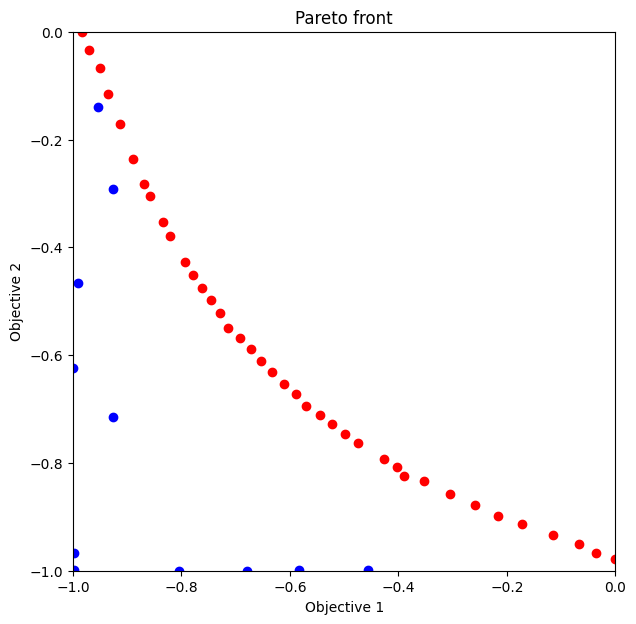

In [ ]:
plot_pareto_front(res_ParEGO)

#### 劣解領域体積

In [ ]:
res_ParEGO.pareto.volume_in_dominance([-1,-1],[0,0])

0.32877907991633726

### 非優越ソート

In [ ]:
policy = physbo.search.discrete_unified.Policy(test_X=test_X, num_objectives=2)
policy.set_seed(seed)

unify_method = physbo.search.unify.NDS()

policy.random_search(max_num_probes=10, simulator=simu)
res_NDS = policy.bayes_search(max_num_probes=40, simulator=simu, unify_method=unify_method, score='EI', interval=5)

#### パレート解のプロット

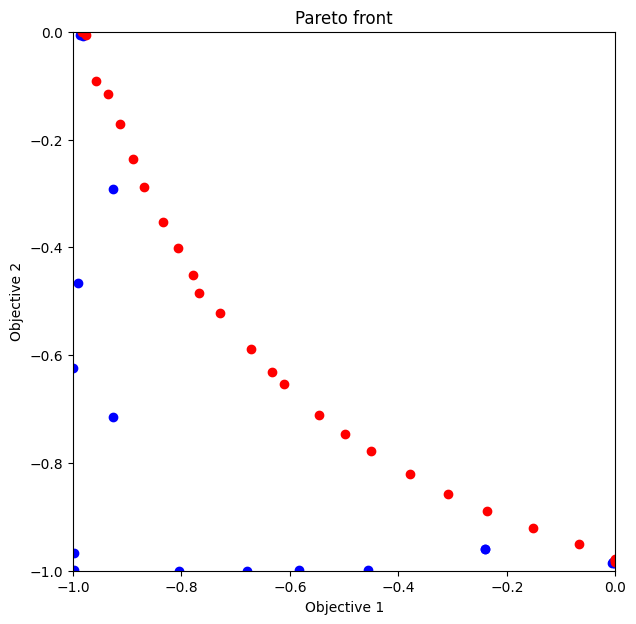

In [ ]:
plot_pareto_front(res_NDS)

#### 劣解領域体積

In [ ]:
res_NDS.pareto.volume_in_dominance([-1,-1],[0,0])

0.3200467412741881